# Fitting Saturation-based Simulation Data Changes
In this notebook, we try to fit intensity data generated using a saturation based method. The mu_a for each of the maternal and fetal layer are based on a set oxygen saturation and HB concentration. The impact of all other pigments on mu_a are ignored. In this notebook, we try to fit the difference between 2 sets of measurements.


# Instructions
I have the parameter search in one of the cells. Run eveerything above it to be able to run that cell.
If you don't want to search, ignore that cell and run everything above and below. 

# V2

In [143]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization, generate_differential_data_loaders, DifferentialCombinationDataset
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU, PerceptronBD, PerceptronDO, PerceptronBN
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity, create_ratio_and_intensity
from inverse_modelling_tfo.misc.misc_training import set_seed
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


In [144]:
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl')
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Interpolate intensity to remove noise
data = interpolate_exp(data, weights=[1, 0.8])
data['Intensity'] = data['Interpolated Intensity']
data = data.drop(columns='Interpolated Intensity')

# Manual log(intensity) normalization
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log


data = create_ratio_and_intensity(data, True)
# data = create_ratio(data, True)
# data = create_spatial_intensity(data)

data.dropna(inplace=True)
data.head()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10,14,19,23,28,...,55_2.0,59_2.0,64_2.0,68_2.0,73_2.0,77_2.0,82_2.0,86_2.0,91_2.0,95_2.0
0,2.0,12.0,0.9,0.11,0.100,-0.480386,-2.623673,-4.576879,-5.702919,-6.686932,...,-11.358381,-11.711740,-12.210222,-12.655790,-13.271930,-13.812146,-14.545983,-15.179238,-16.027416,-16.750309
1,2.0,12.0,0.9,0.11,0.225,-0.481023,-2.627596,-4.588893,-5.722310,-6.715494,...,-11.382127,-11.737660,-12.238768,-12.686365,-13.304953,-13.847055,-14.583165,-15.218171,-16.068457,-16.792972
2,2.0,12.0,0.9,0.11,0.350,-0.481700,-2.631798,-4.601607,-5.742794,-6.745674,...,-11.405223,-11.762845,-12.266471,-12.716009,-13.336930,-13.880828,-14.619094,-15.255757,-16.108029,-16.834069
3,2.0,12.0,0.9,0.11,0.475,-0.482420,-2.636328,-4.615141,-5.764560,-6.777781,...,-11.427687,-11.787314,-12.293352,-12.744741,-13.367884,-13.913485,-14.653790,-15.292014,-16.146153,-16.873619
4,2.0,12.0,0.9,0.11,0.600,-0.483187,-2.641256,-4.629645,-5.787851,-6.812205,...,-11.449536,-11.811086,-12.319428,-12.772583,-13.397835,-13.945047,-14.687274,-15.326963,-16.182847,-16.911642


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [145]:
## Y -> Target
# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
# y_columns = ['Maternal Saturation']
# y_columns = ['Maternal Hb Concentration']
y_column = 'Fetal Hb Concentration'
fixed_columns = ['Maternal Wall Thickness', "Fetal Saturation", "Maternal Saturation"]
# y_columns = ['Fetal Hb Concentration']

## X -> Predictors
# x_columns = list(filter(lambda X: '_' in X, data.columns))
# x_columns = list(filter(lambda X: X.isdigit(), data.columns))
x_columns = list(filter(lambda X: X.isdigit(), data.columns)) + list(filter(lambda X: '_' in X, data.columns))

## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_column] = y_scaler.fit_transform(data[y_column].to_numpy().reshape(-1, 1))

## Scale x
# I tried using the same scaling for all to preserve spatial information. Training does not work
# With variable scale the network learns how much weight to give each 
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])


## Model Configuration

In [146]:
from inverse_modelling_tfo.models.train_model import ModelTrainerFactory

IN_FEATURES = len(x_columns) * 2
OUT_FEATURES = 1
datagen_kw = {
    'table' : data,
    'fixed_columns': fixed_columns,
    'data_loader_params' : 
        {
            'batch_size': 64, 'shuffle': True, 'num_workers': 2
        },
    'x_columns': x_columns,
    'differential_column': y_column,
    'data_length': 50000,
    'allow_zero_diff': False,
    'validation_method': HoldOneOut('Maternal Wall Thickness', 12.0),
    'train_split': 0.8,
}

# trainer_factory = ModelTrainerFactory(PerceptronReLU, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_differential_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronBN, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_differential_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronDO, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_differential_data_loaders, datagen_kw, 100, nn.MSELoss())
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 1, OUT_FEATURES], 'dropout_rates': [0.0, 0.0]}, generate_differential_data_loaders, datagen_kw, 100, nn.MSELoss())


# Hyper Paramter Tuning

In [147]:
# Custom Train Function
def train_with_tuning(iteration_config):
    set_seed(42)
    trainer_tuning = trainer_factory.create()
    trainer_tuning.reporting = True     # Report at each epoch to Ray Tune
    if 'batch_size' in iteration_config:
        trainer_tuning.change_batch_size(iteration_config['batch_size'])    # If batch_size needs tuning
    trainer_tuning.set_optimizer(SGD, {'lr': iteration_config["lr"], 'momentum': iteration_config["momentum"]})
    trainer_tuning.run()

In [148]:
# Hyper Parameter Search 
# iteration_config = {
#     "lr" : tune.loguniform(1e-5, 1e-3),
#     # "batch_size": tune.choice([32, 16, 8]),
#     # "model": tune.choice([[40, 5, 1], [40, 10, 1], [40, 5, 2, 1]]),
#     "momentum": tune.uniform(0.9, 0.99),
# }
# scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=40, grace_period=5, reduction_factor=2)
# reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
# result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
#                   num_samples=50, resources_per_trial={"cpu": 4, "gpu": 0.05},)

# best_trial = result.get_best_trial("combined_loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
# print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [149]:
# best_trial.config

# Custom Training

In [150]:
# Train Model with the given params.
set_seed(42)
trainer = trainer_factory.create()
trainer.change_batch_size(256)
# trainer.set_optimizer(SGD, {'lr': best_trial.config['lr'], 'momentum': best_trial.config['lr']["momentum"]})
trainer.set_optimizer(SGD, {'lr': 1e-4, 'momentum': 0.90})
trainer.epochs = 100
trainer.run()

In [151]:
# trainer.run()

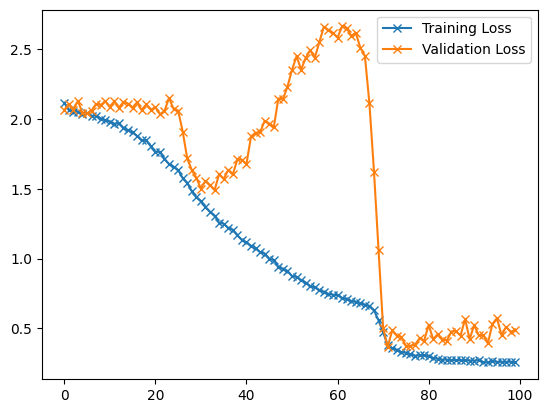

In [152]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [153]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=120, out_features=1, bias=True)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.0, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=1, out_features=1, bias=True)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
        DataLoader Params: 
            Batch Size: 256
            Validation Method: Holds out fMaternal Wall Thickness columns 12.0 for validation. The rest are used             for training
        Loss:
            Train Loss: 0.25621362011523763
            Val. Loss: 0.49038335829973223


In [154]:
x_data = DifferentialCombinationDataset(data, fixed_columns, x_columns, y_column, 50000, False)
truth_column = []
prediction_column = []
loss_column = []
tissue_fixed_params = []

with torch.no_grad():
    for i, current_sample in enumerate(x_data):
        inputs, labels = current_sample
        inputs = inputs.view(1, -1).cuda()
        labels = labels.view(1, -1).cuda()
        outputs = trainer.model(inputs)
        loss = trainer.criterion(outputs, labels)

        # Bookkeeping
        truth_column.append(labels.item())
        prediction_column.append(outputs.item())
        loss_column.append(loss.item())
        tissue_fixed_params.append(x_data.split_fixed_columns[x_data.randomized_indices_list[i]])


tissue_fixed_params = np.array(tissue_fixed_params)
truth_column = np.array(truth_column).reshape(-1, 1)
prediction_column = np.array(prediction_column).reshape(-1, 1)
loss_column = np.array(loss_column).reshape(-1, 1)

# un-normalize
truth_column = y_scaler.scale_ * truth_column
prediction_column = y_scaler.scale_ * prediction_column
absolute_error = np.abs(truth_column - prediction_column)


merged = np.hstack([tissue_fixed_params, truth_column, prediction_column, loss_column, absolute_error])
merged_df = pd.DataFrame(merged, columns=fixed_columns + ['Truth', 'Predicted', "Train Error", "Absolute Error"])
merged_df.head()

,Maternal Wall Thickness,Fetal Saturation,Maternal Saturation,Truth,Predicted,Train Error,Absolute Error
0,14.0,0.600,0.950,-0.015,-0.012811,0.010648,0.002189
1,14.0,0.475,1.000,0.015,0.018918,0.034104,0.003918
2,8.0,0.600,0.975,0.045,0.037310,0.131417,0.007690
3,4.0,0.350,1.000,-0.015,-0.012986,0.009009,0.002014
4,12.0,0.600,0.950,-0.030,-0.020676,0.193177,0.009324


Text(0, 0.5, 'Count')

<Figure size 640x480 with 0 Axes>

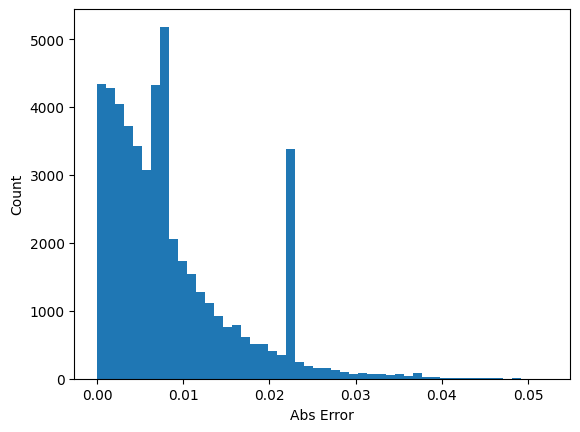

In [155]:
plt.figure()
plt.figure('Error Distribution')
plt.hist(merged_df['Absolute Error'], 50)
plt.xlabel('Abs Error')
plt.ylabel('Count')

In [156]:
merged_df['%Error'] = np.abs((merged_df['Truth'] - merged_df['Predicted'])) / merged_df['Truth'] * 100.

In [157]:
# Top Bad Samples
VIEW_TOP_N = 50
worst_errors = merged_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]
# worst_errors = merged_df['%Error'].argsort()[::-1][:VIEW_TOP_N]
with pd.option_context("display.max_rows", None):
    display(merged_df.iloc[worst_errors, :])

,Maternal Wall Thickness,Fetal Saturation,Maternal Saturation,Truth,Predicted,Train Error,Absolute Error,%Error
35735,12.0,0.100,1.000,-0.015,0.037310,6.080725,0.052310,-348.732716
21104,8.0,0.225,0.900,-0.060,-0.112102,6.032480,0.052102,-86.836629
8339,8.0,0.600,0.900,-0.060,-0.110565,5.681906,0.050565,-84.275634
36000,12.0,0.100,1.000,-0.030,0.018986,5.332507,0.048986,-163.286676
28578,12.0,0.100,1.000,-0.015,0.033907,5.315320,0.048907,-326.046618
49897,12.0,0.100,1.000,-0.015,0.033907,5.315320,0.048907,-326.046618
20535,12.0,0.100,1.000,-0.015,0.033907,5.315320,0.048907,-326.046618
24367,12.0,0.475,1.000,-0.015,0.033166,5.155571,0.048166,-321.109654
40003,8.0,0.100,0.900,-0.060,-0.108161,5.154451,0.048161,-80.268700
29160,12.0,0.100,1.000,-0.030,0.017616,5.038343,0.047616,-158.718986


In [158]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [0.0001153]
Validation Error(non-normalized): [0.00022067]


In [159]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       121
│    └─BatchNorm1d: 2-2                  2
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       2
│    └─Flatten: 2-6                      --
Total params: 125
Trainable params: 125
Non-trainable params: 0

In [160]:
# model_name = 'msat_percep_diff_irsi'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

In [161]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')